In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from skfeature.function.similarity_based.fisher_score import fisher_score, feature_ranking
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-whitegrid')

<br>

In [4]:
texturas = pd.read_excel('BBDD_caEnd_articulo_jmCarot.xlsx', usecols='DG:FKW')
grado = pd.read_excel('BBDD_caEnd_articulo_jmCarot.xlsx', usecols='AT')

na_ind = [47, 91, 94, 97]
texturas = texturas.drop(na_ind)
grado = grado.drop(na_ind)

grado_dico = grado.replace({1:0, 2:1, 3:1})

In [5]:
texturas.shape

(144, 4255)

In [6]:
X_texturas = texturas.values
scaler = StandardScaler()
X_texturas_scaled = scaler.fit_transform(X_texturas)
Y = grado_dico.values.T[0] 

<br>

### Fisher Feature Selection

The larger the fisher score, the more important the feature is

In [7]:
L = fisher_score(X_texturas_scaled, Y)
f = feature_ranking(L)
f

array([361, 353, 552, ..., 645, 597, 343], dtype=int64)

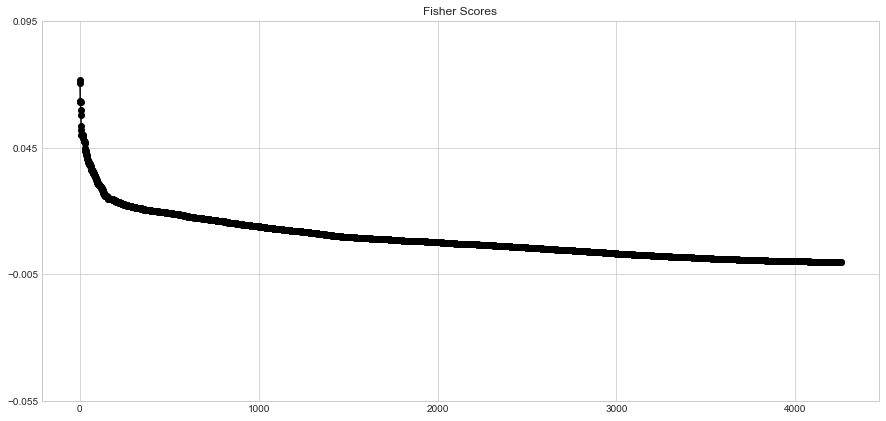

In [8]:
fig = plt.figure(figsize=(15,7))
plt.plot(list(range(len(f))), L[f], '-ok')
plt.grid(True)
plt.yticks(np.arange(min(L)-0.055, max(L)+0.05, step=0.05))
plt.title('Fisher Scores')
plt.show()

<br>

## Cross-validation Fisher Score
### SVM kernel = linear

In [7]:
print(len(f[L[f] > [L[f][0] - (i * 0.001) for i in range(1, 47)][-1]]))

154


In [21]:
modelos = [('linear', 0.7, 0, 100)] 
# (kernel, C, degree, gamma)

hiperparam = {c:None for c in modelos}
for (kernel, C, d, g),_ in hiperparam.items():
    results = {}
    fisher_thresholds = [L[f][0] - (i * 0.001) for i in range(1, 47)]
    for i in fisher_thresholds:
        X_texturas_selected = X_texturas_scaled[:,f[L[f] > i]] # Variables con un valor de Fisher Score mayor que el threshold

        kf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 344)
        probas = np.zeros((X_texturas_selected.shape[0],2))
        for train_index, test_index in kf.split(X_texturas_selected, Y):
            X_train, X_test = X_texturas_selected[train_index], X_texturas_selected[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
            dt = SVC(probability = True, kernel = kernel, C = C, degree = d, gamma = g)
            probas_ = dt.fit(X_train, y_train).predict_proba(X_test)
            probas[test_index, :] = probas_

        fpr, tpr, thresholds = roc_curve(Y, probas[:, 1])
        roc_auc = auc(fpr, tpr)
        results[i] = roc_auc
    hiperparam[(kernel, C, d, g)] = results

In [11]:
{m: max([(v, c) for c, v in results.items()]) for m, results in hiperparam.items()}

{('linear', 2, 0, 'auto'): (0.7193877551020408, 0.028541915283306775),
 ('rbf', 1, 0, 'auto'): (0.6933229813664596, 0.04754191528330678),
 ('sigmoid', 1, 0, 'auto'): (0.6108030168589175, 0.04954191528330678),
 ('poly', 1, 2, 'auto'): (0.6103593611357586, 0.04054191528330678),
 ('linear', 4, 0, 'auto'): (0.7270408163265306, 0.02554191528330678),
 ('rbf', 100, 0, 'auto'): (0.6589396628216504, 0.04254191528330678),
 ('sigmoid', 100, 0, 'auto'): (0.6396406388642413, 0.06954191528330678),
 ('poly', 100, 2, 'auto'): (0.5812999112688554, 0.061541915283306776),
 ('linear', 5, 0, 'auto'): (0.7303682342502218, 0.02554191528330678),
 ('rbf', 0.01, 0, 'auto'): (0.6809006211180124, 0.04454191528330678),
 ('sigmoid', 0.01, 0, 'auto'): (0.5759760425909494, 0.04954191528330678),
 ('poly', 0.01, 2, 'auto'): (0.5892857142857143, 0.03854191528330678),
 ('linear', 7, 0, 100): (0.7179458740017747, 0.02554191528330678),
 ('rbf', 1, 0, 100): (0.5888420585625554, 0.06354191528330677),
 ('sigmoid', 1, 0, 100):

In [19]:
dic_results ={
 ('linear', 1, 0, 'scale'): (0.7233806566104704, 0.028541915283306775),
 ('rbf', 1, 0, 'scale'): (0.6846716947648626, 0.04354191528330678),
 ('sigmoid', 1, 0, 'scale'): (0.5963842058562555, 0.04954191528330678),
 ('poly', 1, 2, 'scale'): (0.6028172138420584, 0.04054191528330678),
 ('linear', 100, 0, 'scale'): (0.7150621118012424, 0.02554191528330678),
 ('rbf', 100, 0, 'scale'): (0.654946761313221, 0.04254191528330678),
 ('sigmoid', 100, 0, 'scale'): (0.6230035492457853, 0.04954191528330678),
 ('poly', 100, 2, 'scale'): (0.6034826974267967, 0.03954191528330678),
 ('linear', 0.01, 0, 'scale'): (0.6987577639751553, 0.02554191528330678),
 ('rbf', 0.01, 0, 'scale'): (0.689773735581189, 0.04254191528330678),
 ('sigmoid', 0.01, 0, 'scale'): (0.5735359361135759, 0.04954191528330678),
 ('poly', 0.01, 2, 'scale'): (0.5939440993788819, 0.04154191528330678),
 ('linear', 0.02, 0, 'auto'): (0.6942102928127774, 0.02754191528330678),
 ('linear', 0.3, 0, 'auto'): (0.7192768411712511, 0.02754191528330678),
 ('linear', 0.4, 0, 'auto'): (0.7254880212954747, 0.028541915283306775),
 ('linear', 0.5, 0, 100): (0.7146184560780834, 0.02754191528330678),
 ('linear', 0.7, 0, 100): (0.7305900621118013, 0.02654191528330678),
 ('linear', 0.9, 0, 100): (0.7281499556344276, 0.028541915283306775),
 ('poly', 0.02, 2, 'auto'): (0.5959405501330968, 0.04854191528330678),
 ('poly', 0.3, 2, 'auto'): (0.6021517302573203, 0.03854191528330678),
 ('poly', 0.4, 2, 'auto'): (0.5988243123336291, 0.04154191528330678),
 ('poly', 0.5, 2, 'auto'): (0.5974933451641526, 0.030541915283306777),
 ('poly', 0.7, 2, 'auto'): (0.6141304347826088, 0.04154191528330678),
 ('poly', 0.9, 2, 'auto'): (0.6079192546583851, 0.04654191528330678),
 ('rbf', 0.02, 0, 'auto'): (0.6959849157054125, 0.02554191528330678),
 ('rbf', 0.3, 0, 'auto'): (0.6913265306122449, 0.04254191528330678),
 ('rbf', 0.4, 0, 'auto'): (0.6855590062111802, 0.04254191528330678),
 ('rbf', 0.5, 0, 100): (0.5808562555456965, 0.06754191528330677),
 ('rbf', 0.7, 0, 100): (0.5629991126885537, 0.05554191528330678),
 ('rbf', 0.9, 0, 100): (0.5908385093167701, 0.06554191528330677),
 ('sigmoid', 0.02, 0, 'auto'): (0.5830745341614907, 0.04954191528330678),
 ('sigmoid', 0.3, 0, 'auto'): (0.57952528837622, 0.04954191528330678),
 ('sigmoid', 0.4, 0, 'auto'): (0.5773070097604259, 0.04954191528330678),
 ('sigmoid', 0.5, 0, 100): (0.566659272404614, 0.04954191528330678),
 ('sigmoid', 0.7, 0, 100): (0.5983806566104702, 0.05954191528330678),
 ('sigmoid', 0.9, 0, 100): (0.6309893522626441, 0.061541915283306776),
 ('linear', 2, 0, 'auto'): (0.7193877551020408, 0.028541915283306775),
 ('rbf', 1, 0, 'auto'): (0.6933229813664596, 0.04754191528330678),
 ('sigmoid', 1, 0, 'auto'): (0.6108030168589175, 0.04954191528330678),
 ('poly', 1, 2, 'auto'): (0.6103593611357586, 0.04054191528330678),
 ('linear', 4, 0, 'auto'): (0.7270408163265306, 0.02554191528330678),
 ('rbf', 100, 0, 'auto'): (0.6589396628216504, 0.04254191528330678),
 ('sigmoid', 100, 0, 'auto'): (0.6396406388642413, 0.06954191528330678),
 ('poly', 100, 2, 'auto'): (0.5812999112688554, 0.061541915283306776),
 ('linear', 5, 0, 'auto'): (0.7303682342502218, 0.02554191528330678),
 ('rbf', 0.01, 0, 'auto'): (0.6809006211180124, 0.04454191528330678),
 ('sigmoid', 0.01, 0, 'auto'): (0.5759760425909494, 0.04954191528330678),
 ('poly', 0.01, 2, 'auto'): (0.5892857142857143, 0.03854191528330678),
 ('linear', 7, 0, 100): (0.7179458740017747, 0.02554191528330678),
 ('rbf', 1, 0, 100): (0.5888420585625554, 0.06354191528330677),
 ('sigmoid', 1, 0, 100): (0.5502440106477374, 0.06254191528330677),
 ('linear', 8, 0, 100): (0.7146184560780834, 0.02554191528330678),
 ('rbf', 100, 0, 100): (0.593944099378882, 0.06354191528330677),
 ('sigmoid', 100, 0, 100): (0.5582298136645962, 0.05954191528330678),
 ('linear', 10, 0, 100): (0.7095164152617568, 0.02554191528330678),
 ('rbf', 0.01, 0, 100): (0.5611135758651287, 0.06754191528330677),
 ('sigmoid', 0.01, 0, 100): (0.6052573203194321, 0.05954191528330678)}

#dict(sorted(dic_results.items(), key=lambda item: item[0]))
{k: v for k, v in sorted(dic_results.items(), key=lambda item: item[1], reverse = True)}

{('linear', 0.7, 0, 100): (0.7305900621118013, 0.02654191528330678),
 ('linear', 5, 0, 'auto'): (0.7303682342502218, 0.02554191528330678),
 ('linear', 0.9, 0, 100): (0.7281499556344276, 0.028541915283306775),
 ('linear', 4, 0, 'auto'): (0.7270408163265306, 0.02554191528330678),
 ('linear', 0.4, 0, 'auto'): (0.7254880212954747, 0.028541915283306775),
 ('linear', 1, 0, 'scale'): (0.7233806566104704, 0.028541915283306775),
 ('linear', 2, 0, 'auto'): (0.7193877551020408, 0.028541915283306775),
 ('linear', 0.3, 0, 'auto'): (0.7192768411712511, 0.02754191528330678),
 ('linear', 7, 0, 100): (0.7179458740017747, 0.02554191528330678),
 ('linear', 100, 0, 'scale'): (0.7150621118012424, 0.02554191528330678),
 ('linear', 0.5, 0, 100): (0.7146184560780834, 0.02754191528330678),
 ('linear', 8, 0, 100): (0.7146184560780834, 0.02554191528330678),
 ('linear', 10, 0, 100): (0.7095164152617568, 0.02554191528330678),
 ('linear', 0.01, 0, 'scale'): (0.6987577639751553, 0.02554191528330678),
 ('rbf', 0.02, 

In [22]:
results_best_model = hiperparam[('linear', 0.7, 0, 100)]

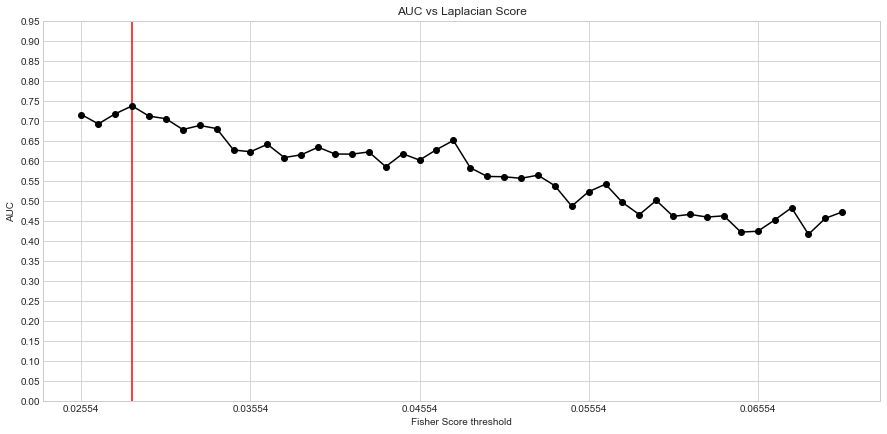

In [26]:
fig = plt.figure(figsize=(15,7))
plt.axvline(x = max([(v, c) for c, v in results_best_model.items()])[1], color = 'r')
plt.plot(results_best_model.keys(), results_best_model.values(), '-ok')
plt.grid(True)
plt.yticks(np.arange(0, 1, step=0.05))
plt.xticks(np.arange(min(fisher_thresholds), max(fisher_thresholds), step = 0.01))
plt.title('AUC vs Laplacian Score')
plt.xlabel('Fisher Score threshold')
plt.ylabel('AUC')
plt.show()

Con un threshold de 0.02 obtenemos el máximo AUC = 0.73

In [27]:
X_texturas_selected = X_texturas_scaled[:,f[L[f] > 0.02654191528330678]] 
    
kf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 344)
probas = np.zeros((X_texturas_selected.shape[0],2))
for train_index, test_index in kf.split(X_texturas_selected, Y):
    X_train, X_test = X_texturas_selected[train_index], X_texturas_selected[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    dt = SVC(probability = True, kernel = 'linear', C = 0.7, gamma = 100)
    probas_ = dt.fit(X_train, y_train).predict_proba(X_test)
    probas[test_index, :] = probas_

In [28]:
probs_df = pd.DataFrame(probas)
probs_df['Y'] = Y
probs_df.to_excel('Predictions_Fisher_Score_SVM.xlsx')